In [1]:
import torch
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments
from datasets import load_dataset, ClassLabel
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score

# 检查设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 从 CSV 加载数据
data_files = {"data": "../datasets/datasets.csv"}
dataset = load_dataset("csv", data_files=data_files)

# 将标签中的 . 替换为 _
def replace_dot_with_underscore(example):
    return {"label": example["label"].replace(".", "_")}
dataset = dataset.map(replace_dot_with_underscore)

# 获取唯一的标签值
unique_labels = sorted(set(dataset["data"]["label"]))
print("唯一的标签值:", unique_labels)

# 将 label 列转换为 ClassLabel 类型
dataset = dataset.cast_column("label", ClassLabel(names=unique_labels))

# 打印数据集信息
print(dataset)

c:\Users\DreamDreamer\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
唯一的标签值: ['cs_AI', 'cs_CE', 'cs_DS', 'cs_IT', 'cs_NE', 'cs_PL', 'cs_SY', 'cs_cv', 'math_AC', 'math_GR', 'math_ST']
DatasetDict({
    data: Dataset({
        features: ['review_id', 'label', 'keywords', 'keysentences', 'abstract'],
        num_rows: 550
    })
})


In [2]:
# 将 keywords、keysentences 和 abstract 拼接成 text
def concatenate_text(example):
    text = ' '.join([str(example['keywords']), str(example['keysentences']), str(example['abstract'])])
    return {'text': text}
dataset = dataset.map(concatenate_text)

# 划分训练集和验证集，80%训练，20%验证
dataset = dataset['data'].train_test_split(test_size=0.2, stratify_by_column='label', seed=42)
train_dataset = dataset['train']
eval_dataset = dataset['test']

# 获取分类个数
num_classes = len(train_dataset.features['label'].names)
print(f"Number of classes: {num_classes}")

# 加载预训练的 RoBERTa 模型和 tokenizer
model_name = 'roberta-base'  # 或者选择其他适合的 RoBERTa 变体，如 'roberta-large'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)
model.to(device)

# 数据预处理
def encode_batch(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=512)  # 调整 max_length 为 512

encoded_train_dataset = train_dataset.map(encode_batch, batched=True, batch_size=32)
encoded_eval_dataset = eval_dataset.map(encode_batch, batched=True, batch_size=32)

Number of classes: 11


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# 定义 compute_metrics 函数
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average='macro')
    return {"accuracy": acc, "macro_f1": macro_f1}

# 设置参数，用 Trainer() 创建实例
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    per_device_train_batch_size=16,  # 根据 GPU 内存调整，RoBERTa 相对于 Longformer 通常占用较少内存
    per_device_eval_batch_size=16,
    warmup_steps=500,
    evaluation_strategy='epoch',
    logging_dir='./logs',
    save_strategy='epoch',  # 保存策略
    load_best_model_at_end=True,  # 在训练结束时加载最好的模型
    metric_for_best_model='macro_f1',  # 用于选择最好的模型的指标
)

# 创建 Trainer 实例
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

c:\Users\DreamDreamer\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\DreamDreamer\AppData\Local\Temp\ipykernel_59816\3038088659.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [9]:
# 训练模型
trainer.train()

# 评估模型
results = trainer.evaluate()
print("Evaluation Results:", results)

 20%|██        | 28/140 [00:36<02:11,  1.17s/it]

{'eval_loss': 2.1867940425872803, 'eval_accuracy': 0.32727272727272727, 'eval_macro_f1': 0.24305819345345034, 'eval_runtime': 3.5482, 'eval_samples_per_second': 31.001, 'eval_steps_per_second': 1.973, 'epoch': 1.0}


 40%|████      | 56/140 [01:26<01:50,  1.31s/it]

{'eval_loss': 2.0982179641723633, 'eval_accuracy': 0.33636363636363636, 'eval_macro_f1': 0.252634940816759, 'eval_runtime': 3.5143, 'eval_samples_per_second': 31.301, 'eval_steps_per_second': 1.992, 'epoch': 2.0}


 60%|██████    | 84/140 [02:18<01:13,  1.31s/it]

{'eval_loss': 1.9673283100128174, 'eval_accuracy': 0.41818181818181815, 'eval_macro_f1': 0.33197976513484534, 'eval_runtime': 3.8931, 'eval_samples_per_second': 28.255, 'eval_steps_per_second': 1.798, 'epoch': 3.0}


 80%|████████  | 112/140 [03:10<00:38,  1.37s/it]

{'eval_loss': 1.8097532987594604, 'eval_accuracy': 0.4636363636363636, 'eval_macro_f1': 0.3943194843434078, 'eval_runtime': 3.6827, 'eval_samples_per_second': 29.869, 'eval_steps_per_second': 1.901, 'epoch': 4.0}


100%|██████████| 140/140 [04:09<00:00,  1.39s/it]

{'eval_loss': 1.6393762826919556, 'eval_accuracy': 0.509090909090909, 'eval_macro_f1': 0.45128818992455355, 'eval_runtime': 2.3116, 'eval_samples_per_second': 47.585, 'eval_steps_per_second': 3.028, 'epoch': 5.0}


100%|██████████| 140/140 [04:16<00:00,  1.83s/it]


{'train_runtime': 256.7673, 'train_samples_per_second': 8.568, 'train_steps_per_second': 0.545, 'train_loss': 2.0042027064732144, 'epoch': 5.0}


100%|██████████| 7/7 [00:01<00:00,  4.20it/s]

Evaluation Results: {'eval_loss': 1.6393762826919556, 'eval_accuracy': 0.509090909090909, 'eval_macro_f1': 0.45128818992455355, 'eval_runtime': 1.9174, 'eval_samples_per_second': 57.369, 'eval_steps_per_second': 3.651, 'epoch': 5.0}


In [10]:
# 获取预测结果
predictions = trainer.predict(encoded_eval_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids



100%|██████████| 7/7 [00:01<00:00,  4.75it/s]


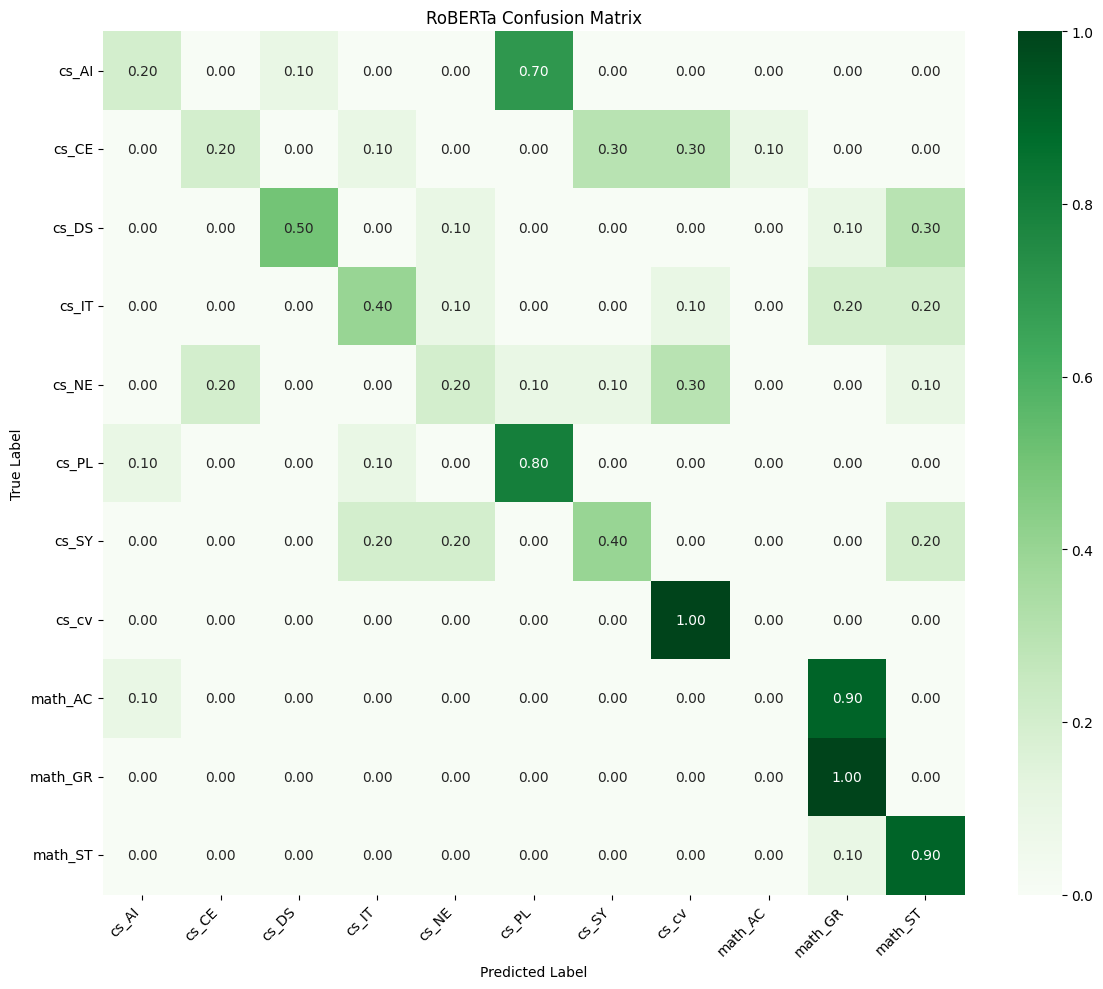

In [14]:
# 计算混淆矩阵
cm = confusion_matrix(labels, preds)
cm_normalized = confusion_matrix(labels, preds, normalize='true')

# 获取标签名称
label_names = unique_labels

# 绘制混淆矩阵
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", xticklabels=label_names, yticklabels=label_names, cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('RoBERTa Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./results/(test)RoBERTa Confusion Matrix.png')
plt.show()


In [12]:

# 计算并打印 Macro F1
macro_f1 = f1_score(labels, preds, average='macro')
print(f"Macro F1 Score: {macro_f1:.4f}")

report = classification_report(labels, preds, target_names=label_names, output_dict=True)  # 使用 output_dict=True 生成字典
print("\nClassification Report:")
print(report)

# 转换分类报告为 DataFrame
df_report = pd.DataFrame(report).transpose()

# 添加 Macro F1 到分类报告
df_report.loc['macro_f1'] = {'precision': None, 'recall': None, 'f1-score': macro_f1, 'support': None}

# 指定 CSV 文件路径
output_csv_path = './results/(test)Roberta_classification_report.csv'

# 保存为 CSV 文件
df_report.to_csv(output_csv_path, index=True)
print(f"Classification report has been saved to {output_csv_path}")

Macro F1 Score: 0.4513

Classification Report:
{'cs_AI': {'precision': 0.5, 'recall': 0.2, 'f1-score': 0.2857142857142857, 'support': 10.0}, 'cs_CE': {'precision': 0.5, 'recall': 0.2, 'f1-score': 0.2857142857142857, 'support': 10.0}, 'cs_DS': {'precision': 0.8333333333333334, 'recall': 0.5, 'f1-score': 0.625, 'support': 10.0}, 'cs_IT': {'precision': 0.5, 'recall': 0.4, 'f1-score': 0.4444444444444444, 'support': 10.0}, 'cs_NE': {'precision': 0.3333333333333333, 'recall': 0.2, 'f1-score': 0.25, 'support': 10.0}, 'cs_PL': {'precision': 0.5, 'recall': 0.8, 'f1-score': 0.6153846153846154, 'support': 10.0}, 'cs_SY': {'precision': 0.5, 'recall': 0.4, 'f1-score': 0.4444444444444444, 'support': 10.0}, 'cs_cv': {'precision': 0.5882352941176471, 'recall': 1.0, 'f1-score': 0.7407407407407407, 'support': 10.0}, 'math_AC': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}, 'math_GR': {'precision': 0.43478260869565216, 'recall': 1.0, 'f1-score': 0.6060606060606061, 'support': 10.0},

C:\Users\DreamDreamer\AppData\Local\Temp\ipykernel_59816\3279632396.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_report.loc['macro_f1'] = {'precision': None, 'recall': None, 'f1-score': macro_f1, 'support': None}
